In [7]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)
import errno

In [8]:
def read_csv_series(path, ts_column="time"):
    """
    Read a time series from a CSV file.

    The CSV file must contain a column with either a UNIX timestamp or a datetime
    string with any format supported by Pandas. 

    Parameters
    -----
    path : path to CSV file

    ts_column : name of the column containing time data, "time" by default

    Returns
    -----
    ret : Pandas Series object with datetime as index
    """

    # read CSV
    df = pd.read_csv(path, parse_dates=[ts_column])
    # convert timestamps to datetime objects using panda's to_datetime
    df[ts_column] = pd.to_datetime(df[ts_column], unit="s")
    # set datetime as index (make time series)
    df.index = df[ts_column]
    # delete original time column
    del df[ts_column]

    # remove rows with duplicated time if there are any, keep first duplicate row
    df = df.loc[~df.index.duplicated(keep="first")]

    df.index.name = ts_column

    return df


def describe_series(df):
    """
    Show basic information about a Pandas Series or DataFrame

    Parameters
    -----
    df : a Pandas Series or DataFrame object
    """

    print("Head:")
    print(df.head())
    print("Stats:")
    print(df.describe())
    print("Count:")
    print(df.count())
    print("Columns: {}".format(df.columns))

    print("Start of time: {}".format(str(df.index[0])))
    print("End of time: {}".format(str(df.index[-1])))


def make_directory_tree(tree, output_dir):
    """
    Create the output directory tree structure specified by `tree` in `output_dir`

    Parameters
    -----
    tree : list of paths to create under `output_dir`

    output_dir : path to root of output directory tree
    """

    for d in tree:
        try:
            path = os.path.join(output_dir, d)
            os.makedirs(path, exist_ok=True)
        except OSError as e:
            if e.errno == errno.EEXIST and os.path.isdir(path):
                print("Path already exists: {}".format(d))
                print("Files may be overwritten")
                continue
            else:
                raise
   

def get_datasets(data_dir):
    """
    Get all .csv filenames from the specified directory

    Parameters
    -----
    data_dir : path to directory containing .csv files

    Returns
    -----
    ret : list containing dataset filenames
    """

    return [f for f in os.listdir(data_dir) if os.path.isfile(
        os.path.join(data_dir, f)) and f.endswith(".csv")]

In [9]:
def rreplace(s):
    a, b, c = s.partition('.')
    return (a + b + c.replace('.', ''))


def preprocess_pollution_report(path, outpath):
    """
    Preprocess a pollution report

    Create a time series of only the PM10 column, no matter what other columns are present.
    Remove values measured over 1000.
    Interpolate missing data for single hours, remove larger periods of NaN values.

    Parameters
    -----
    path : path to input dataset

    outpath : path at which to save the processed dataset

    Returns
    -----
    ret : processed pollution series
    """

    print("Processing {}".format(path))

    # read CSV
    df = pd.read_csv(path, parse_dates=['time'])
    print("Before: ",df.shape)
    # convert timestamps to datetime objects using panda's to_datetime
   
    # Find object columns except time col
    objects = [col for col in df.columns if df[col].dtype == "object"]
    objects.remove('time')
    
    #Fix wrong values caused by typos
    for col in objects:
        for row_no in range(df.shape[0]):
            if not pd.isnull(df.loc[row_no, col]):
                df.loc[row_no, col] = rreplace(df.loc[row_no, col])
                
    # Try to cast every cat variable to numeric(float64), if this doesn't work values will be still categorical
    for col in objects:
        df[col]= pd.to_numeric(df[col],errors='ignore')
    
    # Transform time column to datetime
    ts_column = 'time'
    df[ts_column] = pd.to_datetime(df[ts_column], unit="s")
    
    # set datetime as index (make time series)
    df.index = df[ts_column]
    
    # delete original time column
    del df[ts_column]

    # remove rows with duplicated time if there are any, keep first duplicate row
    df = df.loc[~df.index.duplicated(keep="first")]

    # set name of the index
    df.index.name = ts_column
    
    # create a new datetime index with hourly frequency
    idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
    idx_name = df.index.name
    
     # reindex our series
    df = df.reindex(idx)
    df.index.name = idx_name
    
    # Basic outlier removal for PM10 or missing rows
    # if data is missing for more than 1 hour or PM 10 > 1000 or PM10<0 set to nan then remove
    # otherwise, interpolate if missing within an hour of a known value
    df['PM10'].loc[(df['PM10'] > 1000) | (df['PM10'] < 0)] = np.nan
    df['PM10'] = df['PM10'].interpolate(method="linear", limit=1, limit_area="inside")
    df = df[df['PM10'].notna()]

    print("After: ",df.shape)
    pd.DataFrame(df).to_csv(outpath)

    return df


def preprocess_weather_report(path, outpath):
    """
    Preprocess a weather report

    Remove icon column.
    Set numeric values for precipAccumulation, cloudCover; add "no precip" category for precipType.
    Interpolate values for pressure column.
    One-hot encode categorical columns.

    Parameters
    -----
    path : path to input dataset

    outpath : path at which to save the processed dataset

    Returns
    -----
    ret : processed weather series
    """

    df = read_csv_series(path)

    df = df[1:].drop(["icon"], axis=1)
    df = df.fillna({"precipType": "no precip",
                    "precipAccumulation": 0, "cloudCover": 0})
    #Interpolate pressure such that u fill out each 3 consecutive nans after a value is seen
    df["pressure"].interpolate(inplace=True, limit=3)

    # check for columns with discrete values, one-hot encode them
    categorical_column_names = list(
        df.select_dtypes(include=["object"]).columns)
    # cannot one-hot encode NaN values
    for column_name in categorical_column_names:
        one_hot = pd.get_dummies(df[column_name])
        df = df.join(one_hot)

    df = df.drop(categorical_column_names, axis=1)

    pd.DataFrame(df).to_csv(outpath)

    return df


def combine_reports(df_pollution, df_weather, outpath):
    """
    Produce a combined report from pollution and weather reports

    Parameters
    -----
    df_pollution : pollution series

    df_weather : weather series

    outpath : path at which to save the combined dataset
    """

    df = pd.concat([df_pollution, df_weather], axis=1)
    # drop columns with NaN for PM10
    df = df.dropna(subset=["PM10"])

    # save combined dataset
    pd.DataFrame(df).to_csv(outpath)


def run(input_dir, output_dir):
    """
    Iterate over the input datasets and process them, generating new datasets in output directory.

    Parameters
    -----
    input_dir : path to directory containing raw pollution and weather data

    output_dir : output directory for storing processed data
    """
    make_directory_tree(["pollution", "weather", "combined"], output_dir)

    pollution_reports = sorted([f for f in os.listdir(
        os.path.join(input_dir, "pollution")) if
                                os.path.isfile(os.path.join(input_dir, "pollution", f)) and f.endswith(".csv")])
    weather_reports = sorted([f for f in os.listdir(
        os.path.join(input_dir, "weather")) if
                              os.path.isfile(os.path.join(input_dir, "weather", f)) and f.endswith(".csv")])

    for pollution_report, weather_report in zip(pollution_reports, weather_reports):
        loc = pollution_report.split('.')[0].split('_')[-1]
        if loc != weather_report.split('.')[0].split('_')[-1]:
            raise ValueError("Pollution and weather report for different place! {} and {}".format(
                pollution_report, weather_report))

        print("Processing reports for {}".format(loc))
        df_pollution = preprocess_pollution_report(os.path.join(input_dir, "pollution", pollution_report), os.path.join(
            output_dir, "pollution", pollution_report))
        df_weather = preprocess_weather_report(os.path.join(input_dir, "weather", weather_report), os.path.join(
            output_dir, "weather", weather_report))
        combine_reports(df_pollution, df_weather, os.path.join(
            output_dir, "combined", loc + ".csv"))


## Ideas for extra pre(pre)processing steps here - testing center data

In [2]:
# use helper function to read pollution time series
df = read_csv_series("../data/raw/pollution/pollution_report_centar.csv")
describe_series(df)

Head:
                     AQI    CO  CO2   NO2     O3   PM10   PM25   SO2
time                                                                
2015-01-01 00:00:00  NaN  0.29  NaN  9.14  54.99  30.02  33.84  7.76
2015-01-01 01:00:00  NaN  0.27  NaN  7.28  59.36  30.21  32.11  9.55
2015-01-01 02:00:00  NaN  0.18  NaN  8.11  59.57   29.4  30.34  8.11
2015-01-01 03:00:00  NaN   0.2  NaN  9.51  57.18  28.83   29.2  8.11
2015-01-01 04:00:00  NaN  0.19  NaN  9.12  57.91  27.69  27.28  8.75
Stats:
               CO2
count  6279.000000
mean   3360.402564
std    2139.463756
min     400.000000
25%     400.000000
50%    3840.000000
75%    4996.000000
max    7466.000000
Count:
AQI     21726
CO       6107
CO2      6279
NO2      9265
O3      23867
PM10    36358
PM25    27689
SO2      6378
dtype: int64
Columns: Index(['AQI', 'CO', 'CO2', 'NO2', 'O3', 'PM10', 'PM25', 'SO2'], dtype='object')
Start of time: 2015-01-01 00:00:00
End of time: 2020-03-08 17:00:00


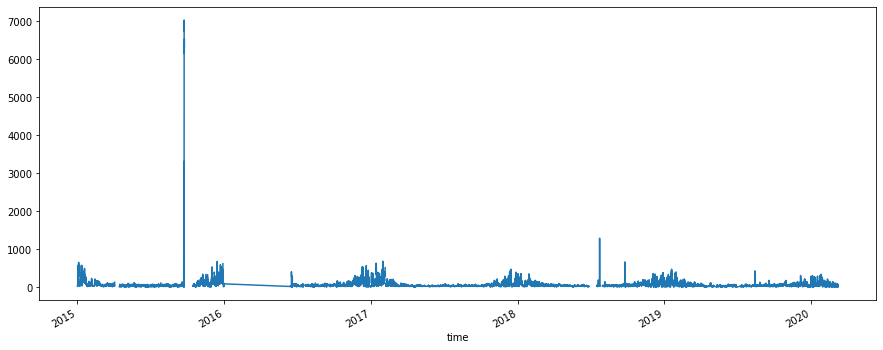

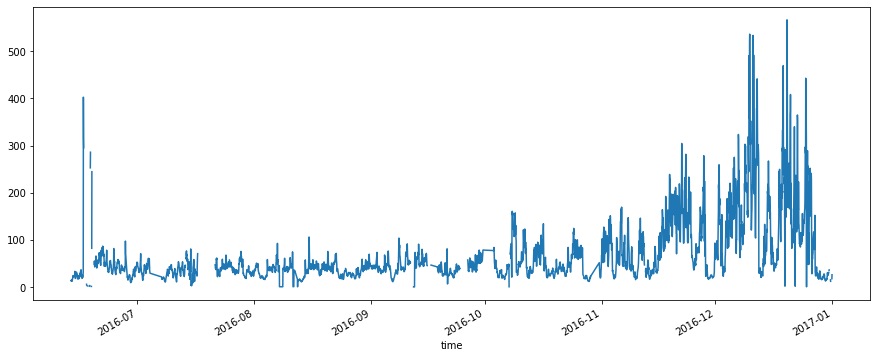

In [3]:
# convert series values to numeric type (np.float64 by default)
# place NaN values in rows with invalid format
df = pd.to_numeric(df["PM10"], errors="coerce")

# plot the complete PM10 time series
plt.figure(figsize=(15, 6))
df.plot()
plt.show()

# plot the PM10 time series for 2016 only
plt.figure(figsize=(15, 6))
df["2016"].plot()
plt.show()

From the time series plots it can be seen that in the period from around 2016-01 to 2016-07 there is no data. We cannot interpolate such a large period of time, so we can safely remove it from our dataset.

First, we will reindex the series for the complete time period, from start to end, in order to see how much data we are actually missing. So, not only will we account for rows in which the value is NaN, but we will also add rows with NaN values for missing timestamps.

In [4]:
# create a new datetime index with hourly frequency
idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
idx_name = df.index.name
# reindex our series
df = df.reindex(idx)
df.index.name = idx_name
print("Total rows: {}".format(len(df)))
print("Number of NaN rows: {}".format(df.isna().sum()))

# if data is missing for more than 1 hour, remove those rows
# otherwise, interpolate
df = df.interpolate(method="linear", limit=1, limit_area="inside")
df = df.dropna()
print("Number of rows after interpolation: {}".format(len(df)))

Total rows: 45450
Number of NaN rows: 9112
Number of rows after interpolation: 37462


Another thing to notice from the plots is that on 2015-09-23 and 2015-09-24 the sensor measurements extend way beyond the next highest measured value. We can assume that this is due to a sensor fault and the measured values are invalid, but anyways we need to remove/interpolate these values because they might be a cause for bad model performance later.

Also, we can also set to NaN and then interpolate or remove negative values for PM10 since it is obvious that they are invalid.

In [5]:
# assign NaNs to values greater than 1000 or negative and interpolate/drop again
df.loc[(df > 1000) | (df < 0)] = np.nan
df = df.interpolate(method="linear", limit=1, limit_area="inside")
df = df.dropna()
print("Number of rows after outlier removal: {}".format(len(df)))

Number of rows after outlier removal: 37439


At this point we need to re-evaluate the dataset to see how it transformed.

count    37439.000000
mean        58.571393
std         61.076920
min          0.000000
25%         26.680000
50%         39.000000
75%         63.000000
max        815.170000
Name: PM10, dtype: float64


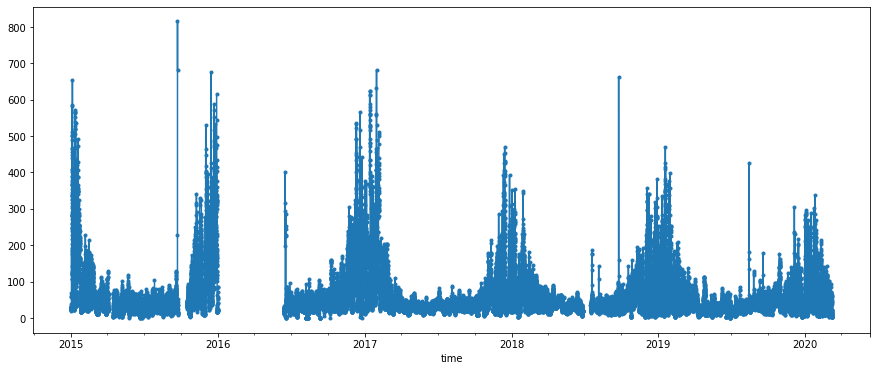

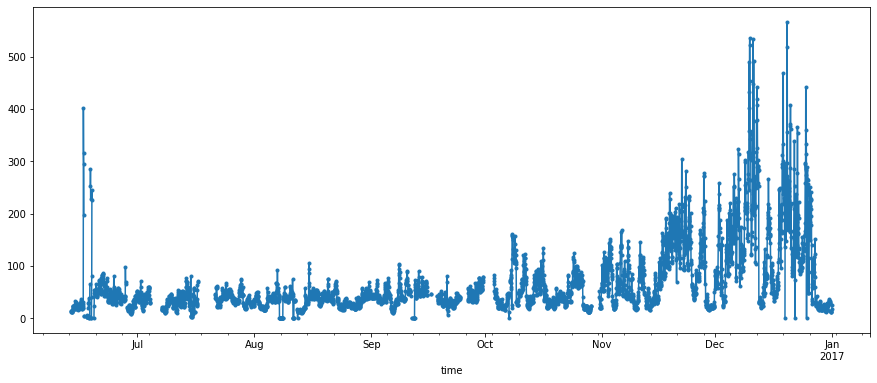

In [6]:
print(df.describe())
# plot the PM10 time series
plt.figure(figsize=(15, 6))
df.reindex(idx).plot(marker=".")
plt.show()

# plot the time series for 2016 only
plt.figure(figsize=(15, 6))
df.reindex(idx)["2016"].plot(marker=".")
plt.show()

In [7]:
# save the dataset as 'data/pollution/centar_pm10.csv'
pd.DataFrame(df).to_csv("../data/processed/pollution/pollution_report_centar.csv")

## Preprocessing Weather Report for Skopje Centar

Head:
                     apparentTemperature  cloudCover  dewPoint  humidity  \
time                                                                       
2014-12-31 23:00:00                 9.03        0.44      5.03      0.58   
2015-01-01 00:00:00                 9.03        0.44      5.03      0.58   
2015-01-01 01:00:00                 4.87        0.44      3.24      0.57   
2015-01-01 02:00:00                 3.62        0.44      3.24      0.62   
2015-01-01 03:00:00                 5.83        0.44      3.24      0.57   

                                    icon  ozone  precipAccumulation  \
time                                                                  
2014-12-31 23:00:00  partly-cloudy-night    NaN                 NaN   
2015-01-01 00:00:00  partly-cloudy-night    NaN                 NaN   
2015-01-01 01:00:00  partly-cloudy-night    NaN                 NaN   
2015-01-01 02:00:00  partly-cloudy-night    NaN                 NaN   
2015-01-01 03:00:00  partly-cloudy-

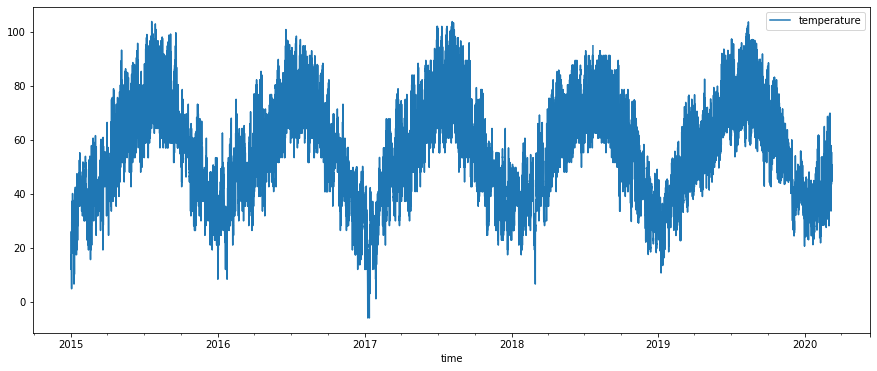

In [8]:
# use helper function to read weather time series
df = read_csv_series("../data/raw/weather/weather_centar.csv")
describe_series(df)

# plot the temperature time series
df.reindex(idx).plot(y=["temperature"], figsize=(15, 6))

In [9]:
# check for gaps in series
# create a new datetime index with hourly frequency
idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
idx_name = df.index.name
# reindex our series
df = df.reindex(idx)
df.index.name = idx_name
print("Total rows: {}".format(len(df)))
print("Number of NaN rows: \n{}".format(df.isna().sum()))

Total rows: 45480
Number of NaN rows: 
apparentTemperature       35
cloudCover              9496
dewPoint                  31
humidity                  35
icon                      31
ozone                  33331
precipAccumulation     45235
precipIntensity         3744
precipProbability       3744
precipType             37225
pressure               23515
summary                   31
temperature               35
uvIndex                 4352
visibility                61
windBearing             8064
windGust               23861
windSpeed                149
dtype: int64


According to the [DarkSky documentation](https://darksky.net/dev/docs#time-machine-request) `precipType` is NaN if `precipAccumulation` is NaN and `precipAccumulation` is NaN if there is no probability of precipation (the value is not observed). Therfore we should change all nan with `no precip` in `precipType` and `0` in `precipAccumulation`

Also replace NaN with 0 for `cloudCover`, remove the first row since the date is out of range and interpolate `pressure` with a limit of 3 hours.

We don't need `icon` column, so we drop it.

The rest of the data is left untouched.

In [10]:
df = df[1:].drop(["icon"], axis=1)
df = df.fillna({'precipType': 'no precip', 'precipAccumulation': 0, 'cloudCover': 0})
df["pressure"].interpolate(inplace=True, limit=3)

In [11]:
# check for columns with discrete values, one-hot encode them
categorical_column_names = list(df.select_dtypes(include=['object']).columns)
# cannot one-hot encode NaN values
for column_name in categorical_column_names:
    one_hot = pd.get_dummies(df[column_name])
    df = df.join(one_hot)

df = df.drop(categorical_column_names, axis=1)

In [12]:
# save weather dataset
pd.DataFrame(df).to_csv("../data/processed/weather/weather_report_centar.csv")

## Join Pollution and Weather Datasets

Head:
                      PM10  apparentTemperature  cloudCover  dewPoint  \
time                                                                    
2015-01-01 00:00:00  30.02                 9.03        0.44      5.03   
2015-01-01 01:00:00  30.21                 4.87        0.44      3.24   
2015-01-01 02:00:00  29.40                 3.62        0.44      3.24   
2015-01-01 03:00:00  28.83                 5.83        0.44      3.24   
2015-01-01 04:00:00  27.69                 5.62        0.44      2.61   

                     humidity  ozone  precipAccumulation  precipIntensity  \
time                                                                        
2015-01-01 00:00:00      0.58    NaN                 0.0              0.0   
2015-01-01 01:00:00      0.57    NaN                 0.0              0.0   
2015-01-01 02:00:00      0.62    NaN                 0.0              0.0   
2015-01-01 03:00:00      0.57    NaN                 0.0              0.0   
2015-01-01 04:00:00 

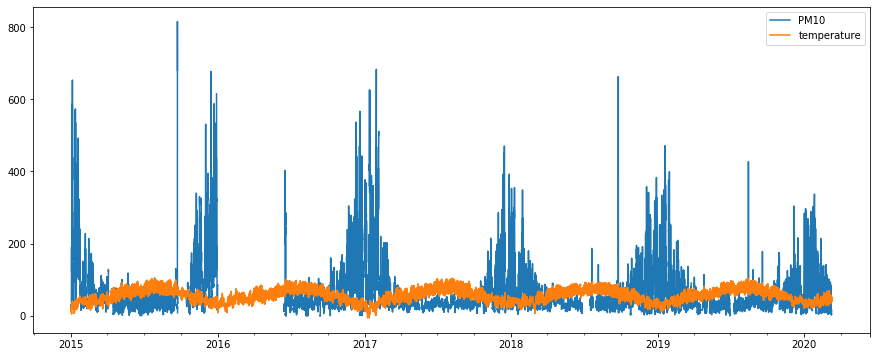

In [13]:
df_pollution = read_csv_series("../data/processed/pollution/pollution_report_centar.csv")
df_weather = read_csv_series("../data/processed/weather/weather_centar.csv")

df = pd.concat([df_pollution, df_weather], axis=1)
describe_series(df)
# drop columns with NaN for PM10
df.dropna(subset=["PM10"])

# plot pollution and temperature
idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
df.reindex(idx).plot(y=["PM10", "temperature"], figsize=(15, 6))

# save combined dataset
pd.DataFrame(df).to_csv("../data/processed/combined/Centar.csv")

## Preprocess All Datasets

In [10]:
# run the preprocessing workflow for all datasets under data/raw, both pollution and weather
# you can see the script at ../pipeline/preprocessing.py
run("../../Data/Pre, raw", "../../Data/Post, combined")

Processing reports for centar
Processing ../../Data/Pre, raw\pollution\pollution_report_centar.csv
Before:  (40284, 9)
After:  (37451, 8)
Processing reports for gazibaba
Processing ../../Data/Pre, raw\pollution\pollution_report_gazibaba.csv
Before:  (34851, 9)
After:  (28808, 8)
Processing reports for karpos
Processing ../../Data/Pre, raw\pollution\pollution_report_karpos.csv
Before:  (37879, 8)
After:  (35868, 7)
Processing reports for kicevo
Processing ../../Data/Pre, raw\pollution\pollution_report_kicevo.csv
Before:  (35663, 8)
After:  (33425, 7)
Processing reports for kumanovo
Processing ../../Data/Pre, raw\pollution\pollution_report_kumanovo.csv
Before:  (38224, 8)
After:  (27807, 7)
Processing reports for lisice
Processing ../../Data/Pre, raw\pollution\pollution_report_lisice.csv
Before:  (32783, 8)
After:  (29284, 7)
Processing reports for miladinovci
Processing ../../Data/Pre, raw\pollution\pollution_report_miladinovci.csv
Before:  (39986, 8)
After:  (38962, 7)
Processing repor